In [1]:
from collections import Counter, defaultdict
from functools import partial
import math, random
import numpy as np
from matplotlib import pyplot as plt
import json

In [2]:
matplotlib inline

# Árvores de Decisão

O diretor de talentos da *DataSciencester* entrevistou vários candidatos à vagas de emprego, com diferentes graus de sucesso. Ele coletou um conjunto de dados que consiste em vários atributos (qualitativos) de cada candidato, bem como se o candidato entrevistou bem ou mal. Você poderia, ele pergunta, usar esses dados para criar um modelo que identifica quais candidatos entrevistariam bem, para que ele não tivesse que perder tempo fazendo entrevistas?

Isso parece ser uma boa opção para uma *árvore de decisão* (*decision tree*), outra ferramenta de modelagem preditiva no kit do cientista de dados.

## O que é uma árvore de decisão?

Uma árvore de decisão usa uma estrutura de árvore para representar um número de possíveis *caminhos de decisão* (*decision paths*) e um resultado para cada caminho.

Se você já jogou o jogo [*Twenty Questions*](https://en.wikipedia.org/wiki/Twenty_Questions), então você está familiarizado com as árvores de decisão. Por exemplo:

* "Estou pensando em um animal".
* "Tem mais de cinco pernas?"
* "Não."
* "É delicioso?"
* "Não."
* "Aparece na parte de trás da moeda australiana de cinco centavos?"
* "Sim."
* “É uma [équidna](https://pt.wikipedia.org/wiki/Equidna-de-focinho-curto)?”
* "Sim!"

Isso corresponde ao caminho:

"Não mais que 5 pernas" $\rightarrow$ "Não é delicioso" $\rightarrow$ "Na moeda de 5 centavos" $\rightarrow$ "Echidna!"

em uma árvore de decisão idiossincrática (e não muito abrangente) "adivinhe o animal":

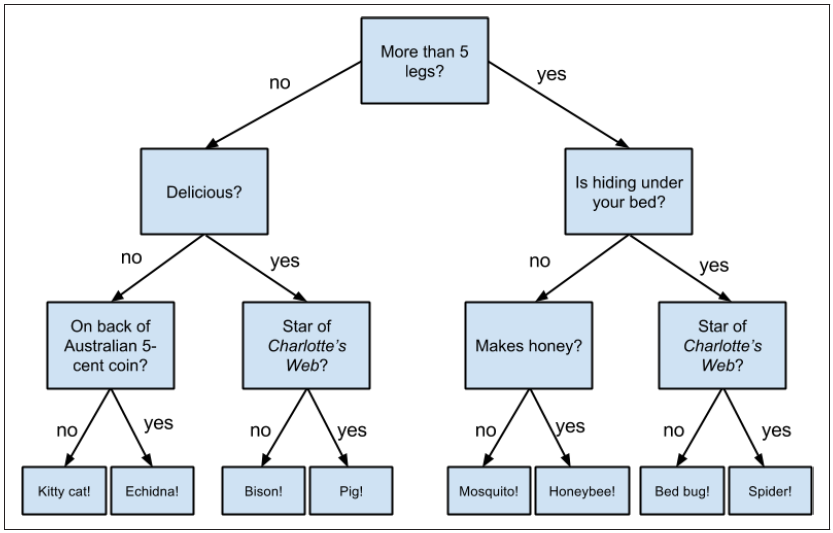

As árvores de decisão possuem muitos pontos positivos. Eles são muito fáceis de entender e interpretar, e o processo pelo qual elas alcançam uma previsão é completamente transparente. Ao contrário dos outros modelos que analisamos até agora, as árvores de decisão podem lidar facilmente com uma combinação de atributos numéricos (por exemplo, número de pernas) e categóricos (por exemplo, delicioso / não delicioso) e podem até classificar dados cujos atributos estão ausentes.

Ao mesmo tempo, encontrar uma árvore de decisão "ótima" para um conjunto de dados de treinamento é computacionalmente um problema muito difícil. (Vamos contornar isso tentando construir uma árvore que seja boa o suficiente em vez de uma ótima, embora para grandes conjuntos de dados isso ainda possa ser muito trabalhoso.) Mais importante, é muito fácil (e muito ruim) construir árvores de decisão que são sobreajustadas (*overfitted*) aos dados de treinamento, e que não generalizam bem para dados não vistos. Vamos procurar maneiras de resolver isso.

A maioria das pessoas divide árvores de decisão em *árvores de classificação* (que produzem saídas categóricas) e *árvores de regressão* (que produzem saídas numéricas). Nesta aula, vamos nos concentrar nas árvores de classificação e trabalharemos no algoritmo *ID3* para aprender uma árvore de decisão a partir de um conjunto de dados rotulados, o que deve nos ajudar a entender como as árvores de decisão realmente funcionam. Para simplificar, [restringir-nos-emos](http://herokuhd.s3-website-sa-east-1.amazonaws.com/images/apos-criticas-e-piadas-o-presidente-michel-temer-disse--em-tom-de-brincadeira-que-nao-usara-mais-a-mesoclise-218368.jpg) a problemas com saídas binárias como "devo contratar este candidato?" Ou "devo mostrar a este visitante do site o anúncio A ou anúncio B?" Ou "comer esta comida que encontrei na geladeira do escritório me deixará doente?

## Entropia

Para construir uma árvore de decisão, precisaremos decidir quais perguntas fazer e em que ordem. Em cada estágio da árvore, há algumas possibilidades que eliminamos e outras que não foram eliminadas. Depois de saber que um animal não tem mais de cinco pernas, eliminamos a possibilidade de ser um gafanhoto. Nós não eliminamos a possibilidade de que seja um pato. Cada questão possível divide as possibilidades restantes de acordo com suas respostas.

Idealmente, gostaríamos de escolher perguntas cujas respostas forneçam muitas informações sobre o que nossa árvore deve prever. Se houver uma única pergunta do tipo "sim/não" em que todas as respostas "sim" sempre correspondem às saídas `True` e todas as respostas "não" às saídas `False` (ou vice-versa), essa seria uma pergunta incrível a ser escolhida. Por outro lado, uma pergunta "sim/não" para a qual nenhuma das respostas oferece muitas informações novas sobre o que a previsão deveria ser, provavelmente essa não é uma boa pergunta a se fazer.

Nós capturamos essa noção de "quanta informação" com a *entropia*. Você provavelmente já ouviu falar que isso significa desordem. Usamos para representar a incerteza associada aos dados.

Imagine que temos um conjunto $S$ de dados, cada membro do qual é rotulado como pertencente a um de um número finito de classes $C_1, \cdots, C_n$. Se todos os pontos de dados pertencerem a uma única classe, não haverá nenhuma incerteza, o que significa que deveríamos ter baixa entropia. Se os pontos de dados forem distribuídos uniformemente pelas classes, há muita incerteza, então deveríamos ter alta entropia.

Em termos matemáticos, se $p_i$ é a proporção de dados rotulados com a classe $c_i$, definimos a entropia como:

$$H(S) = -p_1 \log_2(p_1) - \cdots - p_n \log_2(p_n) = -\sum_{i=1}^n{p_i \log_2(p_i)}$$

com a convenção (padrão) que $0 \log_2(0) = 0$.

Sem nos preocuparmos muito com os detalhes terríveis, cada termo $−p_i \log_2(p_i)$ é não-negativo e está próximo de zero precisamente quando $p_i$ está próximo de zero ou próximo de um:

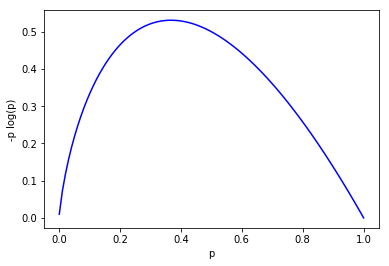

In [3]:
p = np.linspace(0.001,1,100)
plogp = - p * np.log2(p)

fig = plt.figure()
plt.plot(p, plogp, color='blue')


# add a label to the y-axis
plt.ylabel("-p log(p)")
plt.xlabel("p")

fig.savefig("dt1.png", dpi=150)
plt.show()

Isso significa que a entropia será pequena quando cada $p_i$ estiver perto de $0$ ou $1$ (ou seja, quando a maioria dos dados estiver em uma única classe), e será maior quando muitos dos $p_i$ não estiverem próximos de $0$ (ou seja, quando os dados são distribuídos por várias classes). Este é exatamente o comportamento que esperaríamos de uma métrica que captura incerteza de uma distribuição de probabilidade.

É fácil colocar tudo isso em uma função:

In [4]:
def entropy(class_probabilities):
    """given a list of class probabilities, compute the entropy"""
    return sum(-p * math.log(p, 2)
               for p in class_probabilities
               if p)

Nossos dados consistirão em pares (entrada, rótulo), o que significa que precisaremos calcular as probabilidades de classe por conta própria. Observe que, na verdade, não nos importamos com qual rótulo está associado a cada probabilidade, apenas quais são as probabilidades:

In [5]:
def class_probabilities(labels):
    total_count = len(labels)
    return [count / total_count
            for count in Counter(labels).values()]

def data_entropy(labeled_data):
    labels = [label for _, label in labeled_data]
    probabilities = class_probabilities(labels)
    return entropy(probabilities)

## A entropia de uma partição

O que fizemos até agora é calcular a entropia (pense em "incerteza") de um único conjunto de dados rotulados. Agora, cada estágio de uma árvore de decisão envolve fazer uma pergunta cuja resposta particiona os dados em um ou (esperançosamente) mais subconjuntos. Por exemplo, nossa pergunta "tem mais de cinco pernas?" particiona os animais em aqueles com mais de cinco pernas (por exemplo, aranhas) e aqueles que não têm (por exemplo, équidnas).

Do mesmo modo, gostaríamos de alguma noção da entropia resultante do particionamento de um conjunto de dados de uma determinada maneira. Queremos que uma partição tenha baixa entropia se dividir os dados em subconjuntos que possuem baixa entropia (ou seja, são altamente certos) e alta entropia se ela contiver subconjuntos que (são grandes e) têm alta entropia (ou seja, são altamente incertos).

Por exemplo, minha pergunta "moeda de cinco centavos australianos" era bem idiota (embora de muita sorte!), pois particionava os animais restantes naquele ponto em $S_1$ = {équidna} e $S_2$ = {todo o resto}, onde $S_2$ é grande e de alta entropia. (S_1 não tem entropia, mas representa uma fração muito pequena das "classes" restantes).

Matematicamente, se particionamos nossos dados $S$ em subconjuntos $S_1, \cdots, S_m$ contendo proporções $q_1, \cdots, q_m$ dos dados, então calculamos a entropia da partição como uma soma ponderada:

$$H = q_1 H(S_1) + \cdots + q_m H(S_m),$$

que podemos implementar como:

In [6]:
def partition_entropy(subsets):
    """find the entropy from this partition of data into subsets"""
    total_count = sum(len(subset) for subset in subsets)

    return sum( data_entropy(subset) * len(subset) / total_count
                for subset in subsets )


Um problema com essa abordagem é que o particionamento por um atributo com muitos valores diferentes resultará em uma entropia muito baixa devido ao *overfitting*. Por exemplo, imagine que você trabalhe para um banco e esteja tentando criar uma árvore de decisão para prever quais clientes provavelmente não pagarão suas dívidas usando alguns dados históricos como seu conjunto de treinamento. Imagine ainda que o conjunto de dados contenha o CPF de cada cliente. O particionamento no CPF produzirá subconjuntos de uma pessoa, cada qual necessariamente com zero entropia. Mas um modelo que depende do CPF certamente não irá generalizar além do conjunto de treinamento. Por esse motivo, você provavelmente deve tentar evitar (ou distribuí-los, se apropriado) atributos com um grande número de valores possíveis ao criar árvores de decisão.

## Criando uma Árvore de Decisão

O vice-presidente forneceu [os dados](https://www.dropbox.com/s/ncsyvgj0f123l09/interviews.json?dl=0) dos entrevistados, consistindo em pares (de acordo com a sua especificação) (entrada, rótulo), em que cada entrada é um `dict` dos atributos dos candidatos e cada rótulo é `True` (o candidato fez uma boa entrevista) ou `False` (o candidato fez uma entrevista ruim). Em particular, você recebe o nível de cada candidato, seu idioma preferido, se ele está ativo no Twitter e se tem um PhD:

In [7]:
with open('./data/interviews.json') as json_file:  
    inputs = json.load(json_file)
    
print("exemplos de entrada:")
print(inputs[0])
print(inputs[2])

exemplos de entrada:
[{'level': 'Senior', 'lang': 'Java', 'tweets': 'no', 'phd': 'no'}, False]
[{'level': 'Mid', 'lang': 'Python', 'tweets': 'no', 'phd': 'no'}, True]


Nossa árvore consistirá de *nós de decisão* (que fazem uma pergunta e nos direcionam de forma diferente dependendo da resposta) e *nós folha* (que nos dão uma previsão). Vamos construí-la usando o algoritmo *ID3*, que é relativamente simples. Ele opera da seguinte maneira. Digamos que recebamos alguns dados rotulados e uma lista de atributos para considerar na ramificação.

* Se todos os dados tiverem o mesmo rótulo, crie um nó folha que preveja esse rótulo e, em seguida, pare.

* Se a lista de atributos estiver vazia (ou seja, não há mais perguntas possíveis a serem feitas), crie um nó folha que prevê o rótulo mais comum e, em seguida, pare.

* Caso contrário, tente particionar os dados por cada um dos atributos

* Escolha a partição com a entropia de partição mais baixa

* Adicionar um nó de decisão com base no atributo escolhido

* Recorra a cada subconjunto particionado usando os atributos restantes

Isso é conhecido como um algoritmo "guloso" porque, em cada etapa, ele escolhe a melhor opção imediatamente. Dado um conjunto de dados, pode haver uma árvore melhor com um primeiro movimento aparentemente pior. Nesse caso, esse algoritmo não a encontrará. No entanto, ele é relativamente fácil de entender e implementar, o que o torna um bom lugar para começar a explorar as árvores de decisão.

Vamos percorrer manualmente essas etapas no conjunto de dados do entrevistado. O conjunto de dados tem rótulos `True` e `False` e temos quatro atributos nos quais podemos dividir. Portanto, nosso primeiro passo será encontrar a partição com o mínimo de entropia. Começaremos escrevendo uma função que faz o particionamento:

In [8]:
def group_by(items, key_fn):
    """returns a defaultdict(list), where each input item
    is in the list whose key is key_fn(item)"""
    groups = defaultdict(list)
    for item in items:
        key = key_fn(item)
        groups[key].append(item)
    return groups

def partition_by(inputs, attribute):
    """returns a dict of inputs partitioned by the attribute
    each input is a pair (attribute_dict, label)"""
    return group_by(inputs, lambda x: x[0][attribute])


Agora vamos usar a função `partition_by` para calcular a entropia:

In [9]:
def partition_entropy_by(inputs,attribute):
    """computes the entropy corresponding to the given partition"""
    partitions = partition_by(inputs, attribute)
    return partition_entropy(partitions.values())

Então, precisamos apenas encontrar a partição de entropia mínima para todo o conjunto de dados:

In [10]:
for key in ['level','lang','tweets','phd']:
    print(key, partition_entropy_by(inputs, key))

level 0.6935361388961919
lang 0.8601317128547441
tweets 0.7884504573082896
phd 0.8921589282623617


A entropia mais baixa vem da divisão pelo `level`. Por isso, precisamos criar uma subárvore para cada valor `level` possível, que são:

In [11]:
values_level = set()
for cand in inputs:
    values_level.add(cand[0]['level'])
print(values_level)

{'Mid', 'Senior', 'Junior'}


In [12]:
counts = dict()
for v in values_level:
    counts[v] = defaultdict(int)

for cand in inputs:
    level_value = cand[0]['level']
    label = cand[1] 
    counts[level_value][str(label)] += 1
    
print(counts)

{'Mid': defaultdict(<class 'int'>, {'True': 4}), 'Senior': defaultdict(<class 'int'>, {'False': 3, 'True': 2}), 'Junior': defaultdict(<class 'int'>, {'True': 3, 'False': 2})}


Observe que todos os quatro candidatos `Mid` são rotulados como `True`, o que significa que a subárvore `Mid` é simplesmente um nó folha que prevê `True`. Para os candidatos `Senior`, temos uma mistura de `Trues` e `Falses`, então precisamos dividir novamente por algum dos outros atributos:

In [13]:
senior_inputs = [(input, label)
                 for input, label in inputs if input["level"] == "Senior"]

for key in ['lang', 'tweets', 'phd']:
    print(key, partition_entropy_by(senior_inputs, key))

lang 0.4
tweets 0.0
phd 0.9509775004326938


Isso nos mostra que nossa próxima divisão deve estar nos `tweets`, o que resulta em uma partição com entropia $0$. Para esses candidatos de nível sênior, os tweets "sim" sempre resultam em `True`, enquanto os tweets "não" sempre resultam em `False`.

Finalmente, se fizermos a mesma coisa para os candidatos `Junior`, dividiremos pelo atributo `phd`. Veremos que não ter PhD sempre resulta em `True` e ter PhD sempre resulta em `False`.

In [14]:
junior_inputs = [(input, label)
                 for input, label in inputs if input["level"] == "Junior"]

for key in ['lang', 'tweets', 'phd']:
    print(key, partition_entropy_by(junior_inputs, key))

lang 0.9509775004326938
tweets 0.9509775004326938
phd 0.0


Abaixo podemos ver a ilustração dessa árvore de decisão:

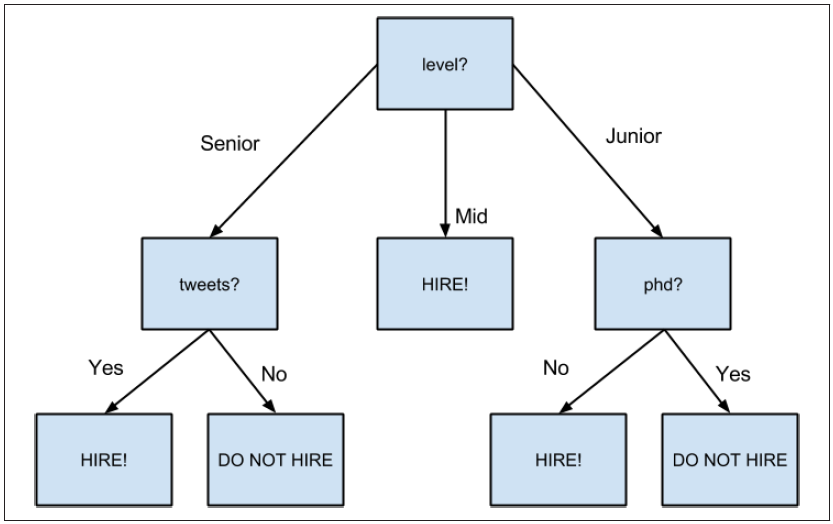

## Juntando Tudo

Agora que já vimos como o algoritmo funciona, gostaríamos de implementá-lo de maneira mais geral. Isso significa que precisamos decidir como queremos representar as árvores. Nós usaremos praticamente a representação mais leve possível. Definimos uma *árvore* como sendo uma das seguintes:

* `True`
* `False`
* uma tupla `(attribute, subtree_dict)`

Aqui, `True` representa um nó de folha que retorna `True` para qualquer entrada, `False` representa um nó de folha que retorna `False` para qualquer entrada e uma tupla representa um nó de decisão que, para qualquer entrada, localiza seu valor de `attribute` e a usando a subárvore correspondente.

Com essa representação, nossa árvore de contratação seria semelhante a:

In [15]:
('level',
 {'Junior': ('phd', {'no': True, 'yes': False}),
  'Mid': True,
  'Senior': ('tweets', {'no': False, 'yes': True})})

('level',
 {'Junior': ('phd', {'no': True, 'yes': False}),
  'Mid': True,
  'Senior': ('tweets', {'no': False, 'yes': True})})

Ainda há a dúvida sobre o que fazer se encontrarmos um valor de atributo inesperado (ou ausente). O que a nossa árvore de contratação deve fazer se encontrar um candidato cujo `level` seja `"intern"`? Vamos lidar com esse caso adicionando uma chave `None` que apenas retorna o rótulo mais comum. (Embora isso seja uma má ideia se `None` for realmente um valor que apareça nos dados.)
Dada essa representação, podemos classificar uma entrada com:

In [16]:
def classify(tree, input):
    """classify the input using the given decision tree"""

    # if this is a leaf node, return its value
    if tree in [True, False]:
        return tree

    # otherwise find the correct subtree
    attribute, subtree_dict = tree

    subtree_key = input.get(attribute)  # None if input is missing attribute

    if subtree_key not in subtree_dict: # if no subtree for key,
        subtree_key = None              # we'll use the None subtree

    subtree = subtree_dict[subtree_key] # choose the appropriate subtree
    return classify(subtree, input)     # and use it to classify the input


Tudo o que resta é construir a representação em árvore a partir de nossos dados de treinamento:

In [17]:
def build_tree_id3(inputs, split_candidates=None):

    # if this is our first pass,
    # all keys of the first input are split candidates
    if split_candidates is None:
        split_candidates = inputs[0][0].keys()

    # count Trues and Falses in the inputs
    num_inputs = len(inputs)
    num_trues = len([label for item, label in inputs if label])
    num_falses = num_inputs - num_trues

    if num_trues == 0:                  # if only Falses are left
        return False                    # return a "False" leaf

    if num_falses == 0:                 # if only Trues are left
        return True                     # return a "True" leaf

    if not split_candidates:            # if no split candidates left
        return num_trues >= num_falses  # return the majority leaf

    # otherwise, split on the best attribute
    best_attribute = min(split_candidates,
        key=partial(partition_entropy_by, inputs))

    partitions = partition_by(inputs, best_attribute)
    new_candidates = [a for a in split_candidates
                      if a != best_attribute]

    # recursively build the subtrees
    subtrees = { attribute : build_tree_id3(subset, new_candidates)
                 for attribute, subset in partitions.items() }

    subtrees[None] = num_trues > num_falses # default case

    return (best_attribute, subtrees)

Na árvore que construímos, cada nó folha consistia inteiramente de entradas `True` ou inteiramente de entradas `False`. Isso significa que a árvore prevê perfeitamente o conjunto de dados de treinamento. Mas também podemos aplicá-lo a novos dados que não estavam no conjunto de treinamento:

In [18]:
tree = build_tree_id3(inputs)
print(tree)

('level', {'Senior': ('tweets', {'no': False, 'yes': True, None: False}), 'Mid': True, 'Junior': ('phd', {'no': True, 'yes': False, None: True}), None: True})


In [19]:
user1 = { "level" : "Junior",
         "lang" : "Java",
         "tweets" : "yes",
         "phd" : "no" }

y_hat1 = classify(tree, user1)

print(user1, "\n->", y_hat1)

print()

user2 = {"level" : "Junior",
         "lang" : "Java",
         "tweets" : "yes",
         "phd" : "yes"}

y_hat2 = classify(tree, user2)

print(user2, "\n->", y_hat2)


{'level': 'Junior', 'lang': 'Java', 'tweets': 'yes', 'phd': 'no'} 
-> True

{'level': 'Junior', 'lang': 'Java', 'tweets': 'yes', 'phd': 'yes'} 
-> False


E também para dados com valores ausentes ou inesperados:

In [20]:
unexpected1 = classify(tree, { "level" : "Intern" } )
print(unexpected1)

unexpected2 = classify(tree, { "level" : "Senior" } )
print(unexpected2)

True
False


Como nosso objetivo era principalmente demonstrar como construir uma árvore, construímos a árvore usando o conjunto de dados inteiro. Como sempre, se estivéssemos realmente tentando criar um bom modelo para algo, teríamos (coletado mais dados e) dividido os dados em subconjuntos de treinamento / validação / teste.

# Florestas Aleatórias

Dada a proximidade com que as árvores de decisão podem se adequar aos dados de treinamento, não é surpresa que elas tenham uma tendência ao *overfit*. Uma maneira de evitar isso é uma técnica chamada florestas aleatórias (*random forests*), na qual construímos várias árvores de decisão e as deixamos votar sobre como classificar as entradas:

In [21]:
def forest_classify(trees, input):
    votes = [classify(tree, input) for tree in trees]
    vote_counts = Counter(votes)
    return vote_counts.most_common(1)[0][0]

Nosso processo de construção de árvores foi determinista, então como obter árvores aleatórias?

Uma peça do mecanismo envolve dados de bootstrap (lembre-se de "*Digressão: O Bootstrap*"). Em vez de treinar cada árvore em todo `input` do conjunto de treinamento, treinamos cada árvore no resultado de `bootstrap_sample(input)`. Como cada árvore é construída usando dados diferentes, cada árvore será diferente de todas as outras árvores. (Um benefício colateral é que é totalmente justo usar os dados não amostrados para testar cada árvore, o que significa que você pode usar todos os seus dados como o conjunto de treinamento, se você for inteligente em como medir o desempenho.) Essa técnica é conhecida como *bootstrap aggregating* ou *bagging*.

Uma segunda fonte de aleatoriedade envolve mudar a maneira como escolhemos o atributo `best_attribute` para dividir. Em vez de observar todos os atributos remanescentes, primeiro escolhemos um subconjunto aleatório deles e, em seguida, dividimos pelo que for melhor:

In [22]:
# if there's already few enough split candidates, look at all of them
if len(split_candidates) <= self.num_split_candidates:
    sampled_split_candidates = split_candidates
# otherwise pick a random sample
else:
    sampled_split_candidates = random.sample(split_candidates,
                                             self.num_split_candidates)

# now choose the best attribute only from those candidates
best_attribute = min(sampled_split_candidates,
                     key=partial(partition_entropy_by, inputs))

partitions = partition_by(inputs, best_attribute)

NameError: name 'split_candidates' is not defined

Este é um exemplo de uma técnica mais ampla, chamada de *ensemble learning*, na qual combinamos vários modelos de aprendizado fracos (tipicamente modelos de alto viés e baixa variância) para produzir um modelo globalmente forte. Florestas aleatórias são um dos modelos mais populares e versáteis que existem.

## Para explorar

* O `scikit-learn` possui muitos modelos de [Árvore de Decisão](http://scikit-learn.org/stable/modules/tree.html). Ele também tem um módulo [*ensemble*](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble) que inclui um `RandomForestClassifier`, bem como outros métodos *ensemble*.

* Nós mal arranhamos a superfície das árvores de decisão e seus algoritmos. A [Wikipédia](https://en.wikipedia.org/wiki/Decision_tree_learning) é um bom ponto de partida para uma exploração mais ampla.